NB to show how to read STScI's precompiled background estimates for the ETC.  Want to make my own bathtub curves of zody vs time.  
To read binary files, following tutorial at http://vislab-ccom.unh.edu/~schwehr/rt/python-binary-files.html

In [106]:
# File description from email V Laidler 23 March 2017
# C structure used to write the stray light binary file.
# One record per file.
#    typedef struct {
#              double pix_ra;
#              double pix_dec;
#              double pos[3];  # pointing unit vector
#              double nonzodi_bg[SL_NWAVE];  // The in-field ism+cib for each pixel.
#            } sl_pix;
#              Then for every day with the target in the FOR,the following three items are written.
#              double day;
#              double zodi_bg[SL_NWAVE];  //  The combined in-field zodi for each pixel.
#              double stray_light_bg[SL_NWAVE];  //The equivalent in-field background from stray light from zodi, stellar,ism, cib
#The wavelength array is the standard one that we converged
#on last year, so they are all on the same wavelength array
#that is SL_NWAVE = 108 elements long.

# JRR update:  The above schema is clearly wrong.  Verified against source code generate_stray_light_with_threads.c
# This is the right schema:
#double RA
#double DEC
#double pos[3]
#double nonzodi_bg[SL_NWAVE]
#int[366] date_map  # This maps dates to indices
#for each day in FOR:
#  double zodi_bg[SL_NWAVE]
#  double stray_light_bg[SL_NWAVE]

In [107]:
import struct
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [108]:
thedir = "/Volumes/Apps_and_Docs/MISSIONS/JWST/Zody_bathtubs/"  # Satchmo
thedir = "/Users/jrrigby1/MISSIONS/JWST/Zody_bathtubs/" # Milk
wave_file = "updated_std_spectrum_wavelengths.txt"  # Standard wavelength array.  Should be SL_NWave=108 long
wave_array = np.loadtxt(thedir + wave_file)
myfiles = ('sl_pix_000593.bin','sl_pix_041303.bin','sl_pix_099422.bin','sl_pix_157139.bin','sl_pix_196512.bin')
myfile = "bg_samples_for_jane/" + myfiles[0]
#myfile = "bg_samples_for_jane/sl_pix_099422.bin" #
SL_NWAVE = len(wave_array)  # should be 108.  Size of wavelength array
sbet_file = open(thedir + myfile)
sbet_data = sbet_file.read()

In [109]:
# Unpack the constant first part
print "File has", len(sbet_data), "bytes, which is", len(sbet_data)/8., "doubles"
size_calendar = struct.calcsize("366i") # bytes, not doubles
partA = struct.unpack(str(5 + SL_NWAVE)+'d', sbet_data[0: (5 + SL_NWAVE)*8])
RA = partA[0]
DEC = partA[1]
pos = partA[2:5]
nonzodi_bg = partA[5:5+SL_NWAVE]

# Unpack the calendar dates, which are integers
date_map = np.array(struct.unpack('366i', sbet_data[(5 + SL_NWAVE)*8  : (5 + SL_NWAVE)*8 + size_calendar]))
#print date_map
print "Out of", len(date_map), "days, these many are legal:", np.sum(date_map >=0)
print "indices of days:", date_map[date_map>=0]
calendar = np.where(date_map >=0)[0]
print "calendar date:", calendar
# So, the index dd in zodi_bg[dd, : ]  corresponds to the calendar day lookup[dd]
Ndays = len(calendar) 
print len(date_map), Ndays
# calendar seems right when Ndays is even.  Calendar seems wrong by 1 when Ndays is odd
# code goes from 0 to 365 days.

File has 373888 bytes, which is 46736.0 doubles
Out of 366 days, these many are legal: 215
indices of days: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214]
calendar date: [  0

In [110]:
# Unpack part B, the time-variable part
zodi_bg        = np.zeros((Ndays,SL_NWAVE))
stray_light_bg = np.zeros((Ndays,SL_NWAVE))
perday = SL_NWAVE*2
partB= struct.unpack(str((len(calendar))*SL_NWAVE*2)+'d', sbet_data[perday*Ndays*-8 : ])

In [111]:
print "Ndays:", Ndays
for dd in range(0, int(Ndays)):
    br1 = dd*perday
    br2 = br1 + SL_NWAVE
    br3 = br2 + SL_NWAVE
    #print "Breaking at:", br1, br2, br3
    zodi_bg[dd, ]        = partB[br1 : br2]
    stray_light_bg[dd, ] = partB[br2 : br3]
#print br3, "was last double" 
#print "DEBUGGING", zodi_bg
#print "DEBUGGING", stray_light_bg

Ndays: 215


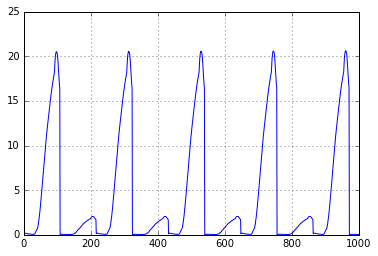

In [112]:
plt.plot(partB)
plt.xlim(0,1000)
#plt.ylim(0,30)
plt.grid()

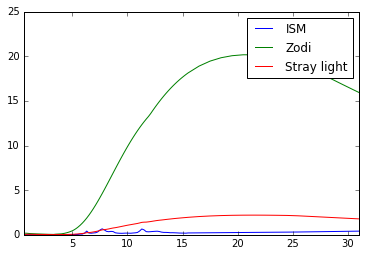

In [113]:
thisday = 100
plt.plot(wave_array, nonzodi_bg, label="ISM")
plt.plot(wave_array, zodi_bg[thisday, :], label="Zodi")
plt.plot(wave_array, stray_light_bg[thisday, :], label="Stray light")
plt.xlim(0.6,31)
plt.legend()

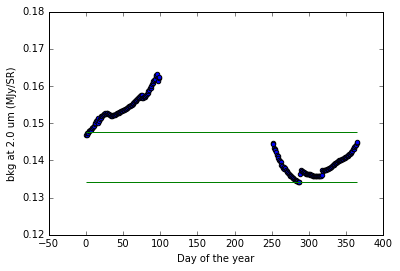

In [114]:
# Plot bathtub curve for 2um
twomicron = 16 # 2.0 micron is index 16 in wave_array
total_2mic = nonzodi_bg[twomicron]*np.ones(Ndays) + stray_light_bg[ : , twomicron] + zodi_bg[ : , twomicron]
#plt.scatter( calendar, zodi_bg[ : , twomicron])  # just infield
#plt.scatter(calendar, stray_light_bg[ : , twomicron])
plt.scatter(calendar, total_2mic)
themin = np.min(total_2mic)
percentiles = (themin, themin*1.1)
plt.hlines(percentiles, 0, 365, color='green')
plt.xlabel("Day of the year")
plt.ylabel("bkg at " + str(wave_array[twomicron]) + " um (MJy/SR)")

When I turn this into a function, will want to return:
return(calendar, RA, DEC, pos, ISM, zody, straylight)